<a href="https://colab.research.google.com/github/theKirill/GensimSample/blob/master/Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gensim

In [0]:
from gensim.models import Word2Vec

In [0]:
import pandas as pd

In [0]:
file_csv = pd.read_csv('drive/My Drive/ForGensim/train.csv') #читаем информацию о каждом изображении

In [20]:
print(file_csv['text'][0])

Add another song to the Cita RomГЎntica playlist. 


In [0]:
intents = file_csv.intents.unique()

In [10]:
intents

array(['AddToPlaylist', 'BookRestaurant', 'GetWeather', 'PlayMusic',
       'RateBook', 'SearchCreativeWork', 'SearchScreeningEvent'],
      dtype=object)

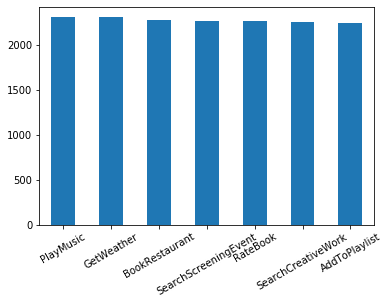

In [11]:
file_csv.intents.value_counts().plot(kind="bar", rot=30)

In [0]:
tokens = []
sentences = file_csv['text']

for sentence in sentences:
  tokens.append(sentence.split())

In [24]:
tokens

[['Add', 'another', 'song', 'to', 'the', 'Cita', 'RomГЎntica', 'playlist.'],
 ['add', 'clem', 'burke', 'in', 'my', 'playlist', 'Pre-Party', 'R&B', 'Jams'],
 ['Add', 'Live', 'from', 'Aragon', 'Ballroom', 'to', 'Trapeo'],
 ['add', 'Unite', 'and', 'Win', 'to', 'my', 'night', 'out'],
 ['Add', 'track', 'to', 'my', 'Digster', 'Future', 'Hits'],
 ['add', 'the', 'piano', 'bar', 'to', 'my', 'Cindy', 'Wilson'],
 ['Add', 'Spanish', 'Harlem', 'Incident', 'to', 'cleaning', 'the', 'house'],
 ['add',
  'The',
  'Greyest',
  'of',
  'Blue',
  'Skies',
  'in',
  'Indie',
  'EspaГ±ol',
  'my',
  'playlist'],
 ['Add',
  'the',
  'name',
  'kids',
  'in',
  'the',
  'street',
  'to',
  'the',
  'plylist',
  'New',
  'Indie',
  'Mix'],
 ['add', 'album', 'radar', 'latino'],
 ['Add', 'Tranquility', 'to', 'the', 'Latin', 'Pop', 'Rising', 'playlist.'],
 ['Add', 'd', 'flame', 'to', 'the', 'Dcode2016', 'playlist.'],
 ['Add', 'album', 'to', 'my', 'fairy', 'tales'],
 ['I',
  'need',
  'another',
  'artist',
  'in'

In [0]:
model = Word2Vec(tokens, size=200, window=10, min_count=3, workers=4)

In [39]:
model.train(tokens, total_examples=len(tokens), epochs=500)

(42147527, 71074500)

In [41]:
model.most_similar('music', topn=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('record', 0.5818523168563843),
 ('songs', 0.5624526739120483),
 ('stuff', 0.5603079795837402),
 ('something', 0.5082290768623352),
 ('melody', 0.47653138637542725)]

In [37]:
model.predict_output_word('add song to playlist')

[('Add', 0.12219187),
 ('mujeres', 0.0058530373),
 ('m', 0.00530504),
 ('y', 0.0051537408),
 ('hombres', 0.0050433893),
 ('Rosana', 0.003131756),
 ('fiesta', 0.0029673993),
 ('mГЎs', 0.0029453987),
 ('Ken', 0.0026758288),
 ('flame', 0.002451563)]